In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PowerTransformer
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
ds = pd.read_csv('credit_data.csv', header=None) # загружаем данные
ds.columns = ['a_'+str(i) for i in range(ds.shape[1]-1)] + ['target'] # пронумеруем признаки и обозначим целевой признак
ds['target'] = ds['target'].map({'+':1, '-':0}) # приведем целевую переменную к численному виду

In [ ]:
ds # посмотри на датасет

,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,a_12,a_13,a_14,target
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,00260,0,0
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,00200,394,0
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,00200,1,0
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,00280,750,0


Проведем краткий стандартный анализ датасета и подготовим его для применения алгоритмой машинного обучения:

In [ ]:
ds.dtypes

a_0        object
a_1        object
a_2       float64
a_3        object
a_4        object
a_5        object
a_6        object
a_7       float64
a_8        object
a_9        object
a_10        int64
a_11       object
a_12       object
a_13       object
a_14        int64
target      int64
dtype: object

Кажется, что признаки 'a_1' и 'a_13' должны быть также числовыми - приведем их к этому виду:

In [ ]:
ds['a_1'] = pd.to_numeric(ds['a_1'], errors='coerce')
ds['a_13'] = pd.to_numeric(ds['a_13'], errors='coerce')

In [ ]:
ds.head()

,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,a_12,a_13,a_14,target
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


In [ ]:
ds['target'].value_counts() # --> датасет сбаллансированный

0    383
1    307
Name: target, dtype: int64

In [ ]:
num_cols = ds.drop(['target'], axis=1).select_dtypes(exclude='O').columns # числовые признаки
cat_cols = ds.select_dtypes(include='O').columns # категориальные признаки

In [ ]:
ds_dummies = pd.get_dummies(ds) # закодируем категориальные признаки

Разделим данные на тренировочную и тестовую выборки: обучение и валидацию будем проводить на тренировочной выборки, а финальную проверку качества модели на тестовой выборке.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(ds_dummies.drop(['target'], axis=1), 
                                                    ds_dummies['target'],
                                                    test_size=0.2,
                                                    random_state=17,
                                                    shuffle=True
                                                   )

In [ ]:
print('Размер тренировочной выборки: {}\nРазмер тестовой выборки: {}'.format(x_train.shape, x_test.shape))

Размер тренировочной выборки: (552, 51)
Размер тестовой выборки: (138, 51)


In [ ]:
x_train.isna().sum()

a_1       10
a_2        0
a_7        0
a_10       0
a_13      11
a_14       0
a_0_?      0
a_0_a      0
a_0_b      0
a_3_?      0
a_3_l      0
a_3_u      0
a_3_y      0
a_4_?      0
a_4_g      0
a_4_gg     0
a_4_p      0
a_5_?      0
a_5_aa     0
a_5_c      0
a_5_cc     0
a_5_d      0
a_5_e      0
a_5_ff     0
a_5_i      0
a_5_j      0
a_5_k      0
a_5_m      0
a_5_q      0
a_5_r      0
a_5_w      0
a_5_x      0
a_6_?      0
a_6_bb     0
a_6_dd     0
a_6_ff     0
a_6_h      0
a_6_j      0
a_6_n      0
a_6_o      0
a_6_v      0
a_6_z      0
a_8_f      0
a_8_t      0
a_9_f      0
a_9_t      0
a_11_f     0
a_11_t     0
a_12_g     0
a_12_p     0
a_12_s     0
dtype: int64

Заполним пропуски в данных:

In [ ]:
x_train['a_1'].fillna(x_train['a_1'].median(), inplace=True) # заполним пропуски медианными значениями
x_train['a_13'].fillna(x_train['a_1'].median(), inplace=True)

Нормализируем и стандартизируем выборку:

In [ ]:
transformer = PowerTransformer(standardize=True) # для нормализации и стандартизации
x_train[num_cols] = transformer.fit_transform(x_train[num_cols]) # применяем к тренировочной выборке
x_test[num_cols] = transformer.transform(x_test[num_cols]) # применяем к тестовой выборке

В sklearn есть две реализации алгоритма опорных векторов - SVC и LinearSVC. Первая реализация работает очень медленно с большими объемами данных, но позволяет решать нелинейные задачи с применением различных ядер. Вторая реализация намного быстрее, но позволяет строить только линейную гиперплоскость. Также вторая реализация не позволяет вернуть предсказания в виде вероятности.

In [ ]:
svc = SVC() # первая реализация алгоритма
linear_svc = LinearSVC(random_state=17) # вторая реализация алгоритма
skf = StratifiedKFold(n_splits=7) # схема для кросс-валидации

cv_score_svc = cross_val_score(svc, x_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1) # прогоняем модель на кросс-валидации
cv_score_linear_svc = cross_val_score(linear_svc, x_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1) # прогоняем модель на кросс-валидации
print('Точность модели SVC на кросс-валидации: %.3f+-%.3f'% (np.mean(cv_score_svc), np.std(cv_score_svc)))
print('Точность модели Linear SVC на кросс-валидации: %.3f+-%.3f'% (np.mean(cv_score_linear_svc), 
                                                                    np.std(cv_score_linear_svc)))

Точность модели SVC на кросс-валидации: 0.862+-0.039
Точность модели Linear SVC на кросс-валидации: 0.842+-0.032


Мы сразу получили неплохую точность с базовыми параметрами модели, теперь попробуем настроить модели на кросс-валидации:

In [ ]:
def val_grid_search(x, y, model, params, cv):
    grid = GridSearchCV(model, param_grid=params, scoring='accuracy', n_jobs=-1, cv=cv)
    grid.fit(x, y)
    print('Лучшая модель на кросс-валидации с параметрами {} и результатом {}'.format(grid.best_params_, 
                                                                                      np.round(grid.best_score_,4)))
    return grid.best_estimator_

In [ ]:
params_svc = {'C': (0.1, 1, 10, 100), 'kernel': ('rbf', 'poly', 'sigmoid'), 'degree': (2,3,5), 'gamma':('scale', 'auto')}
best_svc_model = val_grid_search(x_train, y_train, svc, params_svc, skf)


Лучшая модель на кросс-валидации с параметрами {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'} и результатом 0.875


In [ ]:
params_linear_svc = {'C': (0.01, 0.1, 1, 10), 'penalty': ('l1', 'l2')}
best_linear_svc_model = val_grid_search(x_train, y_train, linear_svc, params_linear_svc, skf)

Лучшая модель на кросс-валидации с параметрами {'C': 0.01, 'penalty': 'l2'} и результатом 0.8624


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.86235916        nan 0.85331757        nan 0.84246766
        nan 0.83340288]
  warnings.warn(


Теперь посмотрим как наша модель отработает на тестовой выборке

In [ ]:
x_test['a_1'].fillna(x_test['a_1'].median(), inplace=True) # заполним пропуски медианными значениями
x_test['a_13'].fillna(x_test['a_1'].median(), inplace=True)

In [ ]:
best_svc_model.fit(x_train, y_train)
print('Точность модели на тестовой выборке: %.3f' % accuracy_score(y_test, best_svc_model.predict(x_test)))

Точность модели на тестовой выборке: 0.884


Точность на тестовой выборке близка к точности на валидации, следовательно, наша модель не переобучается и адекватно предсказывает данные, которые никогда не видела. 

Посмотрим матрицу ошибок:

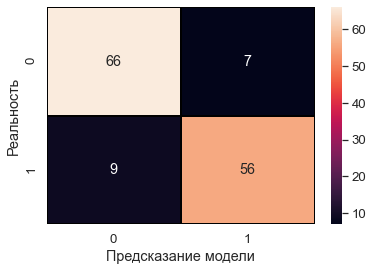

In [ ]:
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix(y_test, best_svc_model.predict(x_test)), 
            annot=True, 
            fmt = '.3g',
            linewidths=0.1,
            linecolor='black'
           );
plt.xlabel('Предсказание модели')
plt.ylabel('Реальность');

In [ ]:
1. SQL query 
train
test

2. SQL query
validation (может быть и может не быть Y)

y_pred = model.predict(X_validation)

acurracy(y_pred, y_valid)

(только от +20000 объектов в датасете)
70% train
20% test
10% valid

In [ ]:
df['ваш признак с предложениями'].value_count()
если предложения стандартные, то использукйте LabelEncoder, OHE
если предложения не станадратные (каждое предложение уникальное), если вы все равно хотите работать

1. str(предложение).split('')
2. import NLTK tokenizer 

